# Google colab/ Kaggle

Pour utiliser le google drive et avoir des informations sur le système utilisé.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#chemin_google_drive = "drive/MyDrive/"

!cat /proc/cpuinfo | grep 'model name'
!cat /proc/meminfo | grep 'MemTotal'

chemin_train = "/kaggle/input/abc-dataset-train/"
chemin_validation = "/kaggle/input/abc-dataset-validation/"

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
MemTotal:       32880784 kB


# Chargement fichier .ply

Pour charger un fichier.ply, on utilise la librarie plyfile (https://pypi.org/project/plyfile/). Note on utilisera plyfile seulement pour l'écriture des fichiers ply. La librarie tqdm permet d'avoir une barre de progression pour une boucle, ce qui est utile pour connaître le temps.

In [2]:
!pip install plyfile

In [3]:
from plyfile import PlyData, PlyElement
from tqdm import tqdm

In [4]:
with open(chemin_train+'0002.ply', 'rb') as f:
    plydata = PlyData.read(f)

# Visualisation fichier .ply

Pour confirmer le chargement, on utilise la fonction de scatter de matploblib pour visualiser le nuage de points (https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html).

In [5]:
import matplotlib.pyplot as plt

In [6]:
def afficher(plydata):
    x = plydata.elements[0].data['x']
    y = plydata.elements[0].data['y']
    z = plydata.elements[0].data['z']
    red = plydata.elements[0].data['red']
    green = plydata.elements[0].data['green']
    blue = plydata.elements[0].data['blue']
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')

    colors = [(r/255,g/255,b/255,1) for r,g,b in zip(red, green, blue)]
    ax.scatter(x, y, z, marker='.', s=1, c=colors)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

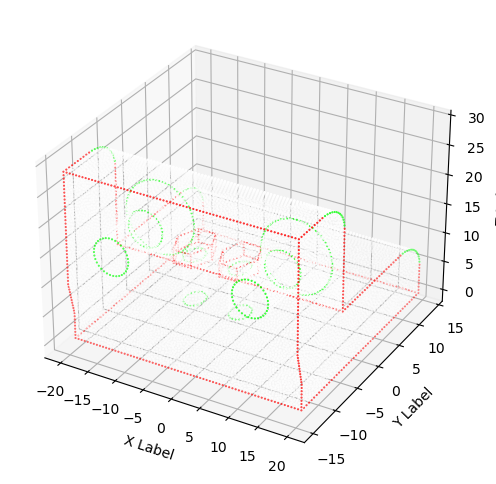

In [7]:
afficher(plydata)

# Traitement des données .ply

Pour utiliser le .ply dans notre modèle PyTorch (https://pytorch.org/), on passera par un Dataset modifié qui lors du chargement du .ply rajoutera les kppv comme information à l'aide de la librarie sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [8]:
import torch
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
class CustomDataset(Dataset):
    def __init__(self, ply_data, lb_data, k):
        self.k = k+1
        self.hasLabel = True
        if lb_data == None:
            self.hasLabel = False
        self.data, self.labels = self.load_data(ply_data, lb_data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        return sample, label

    def load_data(self, ply_data, lb_data):
        while "end_header" not in ply_data.readline():
            pass     
        
        points = np.loadtxt(ply_data, dtype=np.float32, ndmin=2, usecols=(0, 1, 2))
        
        if self.hasLabel:
            lb_data.readline()        
            labels = np.loadtxt(lb_data, dtype=np.int64) 
        else:
            labels = np.empty(len(points)) * np.nan


        neighbors = NearestNeighbors(n_neighbors=self.k, n_jobs=-1)
        neighbors.fit(points)
        
        distances, indices = neighbors.kneighbors(points, return_distance=True)
        data = np.zeros((len(points), self.k*3), dtype=np.float32)
        data[:, :3] = points        
        data[:, 3:] = points[indices[:, 1:]].reshape(len(points), -1)

        data = torch.Tensor(data)

        return data, labels

# Définition du modèle

Pour rappel notre modèle prend en entrée un point et ses kppv et donne en sortie son type (si c'est un bord ou non).

In [10]:
import torch.nn as nn

In [11]:
class Model(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(k*3+3, k),
            nn.ReLU(),
            nn.Linear(k, 2)
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

# Données du modèle

Pour l'entraînement on utilisera toutes les pièces du dossier train et pour la validation on utilisera toutes les pièces du dossier validation. Et on utilisera une pièce autre que celle utilisée dans le train pour donner un exemple de résultat (pour l'affichage).

In [12]:
from torch.utils.data import ConcatDataset
from torch.utils.data import TensorDataset

On fait en sorte que les données soient contigues.

In [13]:
def charger_datasets(chemin, fichiers):
    datasets_list = []
    for fichier in tqdm(fichiers):
        with open(chemin+fichier+".lb", 'rb') as data_lb, \
            open(chemin+fichier+".ply", 'r') as data_ply:
            dataset = CustomDataset(data_ply, data_lb, k)
        datasets_list.append((dataset.data, dataset.labels))
        
    data = torch.empty(0)
    labels = torch.empty(0, dtype=torch.long)
    for i in range(len(datasets_list)):
        data = torch.cat((data, datasets_list[i][0]), dim=0)
        labels = torch.cat((labels, torch.from_numpy(datasets_list[i][1])), dim=0)
    return TensorDataset(data, labels)

On définit un dataloader personnalisé pour utiliser la contiguïté des données.

In [14]:
import math

class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle):
        self.dataset = dataset
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.dataset) / self.batch_size)

    def __iter__(self):
        indices = torch.randperm(len(self.dataset))
        for i in range(0, len(indices), self.batch_size):
            end_index = min(i + self.batch_size, len(indices))
            batch_indices = indices[i:end_index]

            data = self.dataset.tensors[0][batch_indices]
            targets = self.dataset.tensors[1][batch_indices]

            yield data, targets            

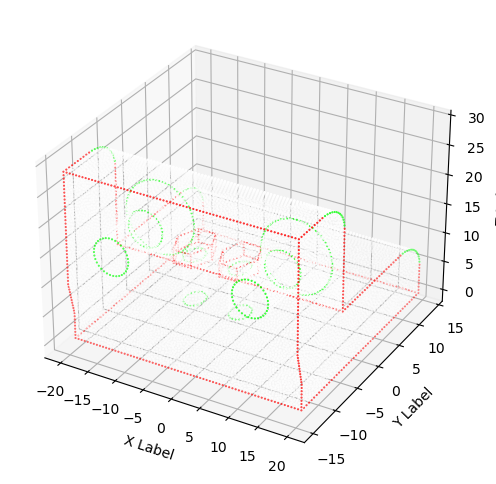

100%|██████████| 104/104 [00:45<00:00,  2.28it/s]


Fin chargement train


100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


Fin chargement validation


In [15]:
k = 10
batch_size = 100

afficher_data_ply = PlyData.read(chemin_train+"0002.ply") #0002 0008
afficher(afficher_data_ply)

with open(chemin_train+"0002.lb", 'rb') as afficher_data_lb, \
    open(chemin_train+"0002.ply", 'r') as afficher_data_ply:
    afficher_dataset = CustomDataset(afficher_data_ply, afficher_data_lb, k)

afficher_dataloader = DataLoader(afficher_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

fichiers = ['0000', '0001', '0002', '0004', '0005', '0008', '0011', '0013', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125', '0126', '0127', '0128', '0160', '0161', '0162', '0163', '0164', '0165', '0166', '0167', '0168', '0169', '0170', '0171', '0172', '0173', '0174', '0175', '0176', '0177', '0178', '0179', '0180', '0181', '0274', '0275', '0276', '0277', '0278', '0279', '0280', '0281', '0989', '0990', '0991', '0992', '0993', '0994', '0995', '0996', '0997', '0998']

train_dataloader = CustomDataLoader(charger_datasets(chemin_train, fichiers), batch_size=batch_size, shuffle=True)  
print("Fin chargement train")

fichiers = ['0141', '0228', '0508', '0658', '0755', '0782', '0820', '0917', '0142', '0229', '0509', '0659', '0756', '0783', '0821', '0918', '0143', '0230', '0510', '0660', '0757', '0784', '0822', '0919', '0144', '0231', '0511', '0661', '0758', '0785', '0823', '0920', '0145', '0232', '0512', '0662', '0759', '0786', '0824', '0921', '0146', '0233', '0513', '0663', '0760', '0787', '0825', '0922', '0147', '0234', '0514', '0664', '0761', '0788', '0826', '0923', '0148', '0235', '0515', '0665', '0762', '0789', '0827', '0924', '0149', '0236', '0516', '0666', '0763', '0790', '0828', '0925', '0150', '0237', '0654', '0667', '0764', '0791', '0829', '0225', '0238', '0655', '0668', '0765', '0817', '0830', '0226', '0239', '0656', '0753', '0766', '0818', '0831', '0227', '0507', '0657', '0754', '0767', '0819', '0916']

validation_dataloader = CustomDataLoader(charger_datasets(chemin_validation, fichiers), batch_size=batch_size, shuffle=False)
print("Fin chargement validation")


# Accélération matérielle

Pour accélérer le temps d'apprentissage on utilisera un GPU (si c'est le cas).

In [16]:
device = ("cuda" if torch.cuda.is_available()
  else "mps" if torch.backends.mps.is_available()
  else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Device: cpu


# Apprentissage du modèle

On définit une fonction train (d'entraînement) avec arrêt prématuré et stockage des loss du dataset train et du dataset validation.

In [17]:
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [18]:
def train(model, num_epochs, train_dataloader, val_dataloader, criterion, optimizer, train_losses, val_losses, patience):
    count = 0
    best_val_loss = float('inf')

    for epoch in tqdm(range(num_epochs)):
        epoch_train_loss = 0
        epoch_val_loss = 0

        model.train()
        for (inputs, labels) in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_loss += loss.item()


        avg_epoch_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(avg_epoch_train_loss)      

        model.eval()
        with torch.no_grad():
            inputs, labels = val_dataloader.dataset.tensors[0].to(device), val_dataloader.dataset.tensors[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            epoch_val_loss += loss.item()

            avg_epoch_val_loss = epoch_val_loss / len(val_dataloader)
            val_losses.append(avg_epoch_val_loss)


            if avg_epoch_val_loss < best_val_loss:
                best_val_loss = avg_epoch_val_loss
                best_model_weights = model.state_dict()
                count = 0
            else:
                count += 1
                if count >= patience:
                    print("Early stop")
                    model.load_state_dict(best_model_weights)
                    break

In [19]:
def afficher_loss(train_losses, val_losses):
    plt.plot(range(1,len(train_losses)+1), train_losses, marker='o', label='Train')
    plt.plot(range(1,len(val_losses)+1), val_losses, marker='o', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

Pour l'apprentissage, on utilise comme loss la Crossentropy et comme optimizer Adam. On utilisera aussi un arrêt prématuré de 5 epochs sur 100 epochs maximums. Et les hypers-paramètres suivant :

 12%|█▏        | 12/100 [11:18<1:22:54, 56.52s/it]

Early stop


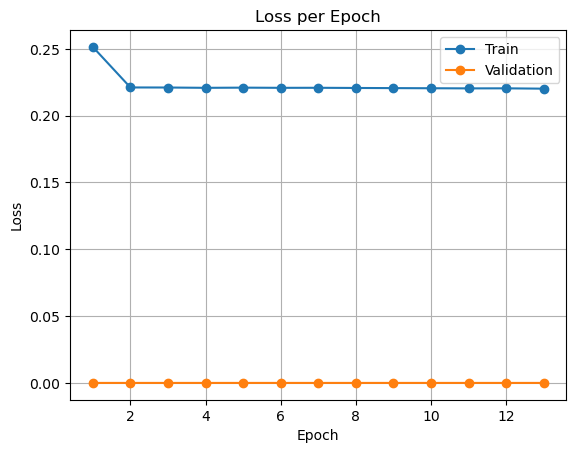

In [20]:
model = Model(k).to(device)

learning_rate = 0.001
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

patience = 5

train_losses = []
val_losses = []

train(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, train_losses, val_losses, patience)

# Sauvegarde du modèle entraîné
# torch.save(model.state_dict(), "modele.pth")

afficher_loss(train_losses, val_losses)

## Résultats

On se réfère aux formules définies à la fin de l'article de PCEDNet.

In [21]:
def precision(TP,FP):
    if (TP + FP) != 0:
        return TP / (TP + FP)
    else:
        return 0

def rappel(TP,FN):
    if (TP + FN) != 0:
        return TP / (TP + FN)
    else:
        return 0

def f1_score(TP, FP, FN):
    precision_value = precision(TP, FP)
    recall_value = rappel(TP, FN)

    if (precision_value + recall_value) != 0:
        return 2 * (precision_value * recall_value) / (precision_value + recall_value)
    else:
        return 0



def mcc(TP, TN, FP, FN):
    numerator = (TP * TN) - (FP * FN)
    denominator = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
    if denominator != 0:
        return numerator / denominator
    else:
        return 0


def accuracy(TP, TN, FP, FN):
    total = TP + TN + FP + FN
    if total != 0:
        return (TP + TN) / total
    else:
        return 0


def iou(TP, FP, FN):
    union = TP + FP + FN
    if union != 0:
        return TP / union
    else:
        return 0

In [22]:
def resultat(model, validation_dataloader):
    fp = 0
    fn = 0
    tp = 0
    tn = 0

    list_predicted = []
    list_labels = []        
    
    model.eval()
    with torch.no_grad():
        inputs, labels = validation_dataloader.dataset.tensors[0].to(device), validation_dataloader.dataset.tensors[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        tp += torch.sum(torch.eq(predicted, labels) & torch.eq(labels, 1)).item()
        tn += torch.sum(torch.eq(predicted, labels) & torch.eq(labels, 0)).item()

        fp += torch.sum(torch.ne(predicted, labels) & torch.eq(labels, 0)).item()
        fn += torch.sum(torch.ne(predicted, labels) & torch.eq(labels, 1)).item()   

    print(fp, tp, fn, tn)

    print("Précision : ", precision(tp, fp))
    print("Rappel : ", rappel(tp, fn))
    print("F1 score :", f1_score(tp,fp,fn))
    print("MCC : ", mcc(tp, tn, fp, fn))
    print("Accuracy : ", accuracy(tp, tn, fp, fn))
    print("IoU : ", iou(tp, fp, fn))

In [23]:
resultat(model, validation_dataloader)

0 0 272213 4122388
Précision :  0
Rappel :  0.0
F1 score : 0
MCC :  0
Accuracy :  0.9380574027084597
IoU :  0.0


## Affichage

In [24]:
def afficher_exemple(model, afficher_dataloader):
    model.eval()
    points = []

    with torch.no_grad():
        for inputs, labels in afficher_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i,j in zip(inputs,predicted):
                if j.tolist() == 0:
                    points.append((i[0].tolist(), i[1].tolist(), i[2].tolist(), 255, 255, 255, 255))
                else:
                    points.append((i[0].tolist(), i[1].tolist(), i[2].tolist(), 255, 0, 0, 255))


    properties = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1'), ('alpha', 'u1')]

    points = np.array(points, dtype=properties)
    vertex_element = PlyElement.describe(points, 'vertex')

    new_ply_data = PlyData([vertex_element])

    #new_ply_data.write('resultats.ply')

    afficher(new_ply_data)

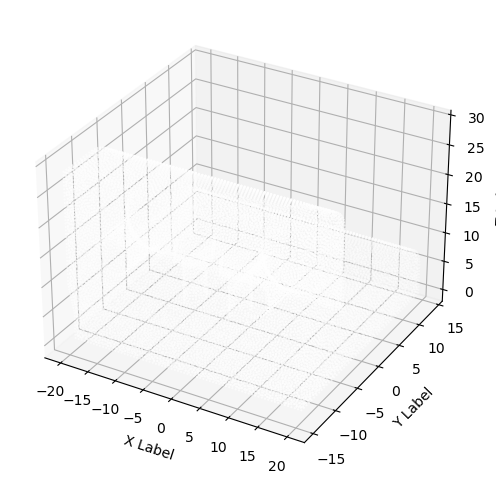

In [25]:
afficher_exemple(model, afficher_dataloader)

# Amélioration

## Augmentation de la complexité du modèle

On va ajouter un batch normalization et un dropout.

In [26]:
class Model2(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(k*3+3, k),
            nn.BatchNorm1d(k),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(k, 2)
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

  6%|▌         | 6/100 [09:03<2:21:49, 90.52s/it]

Early stop


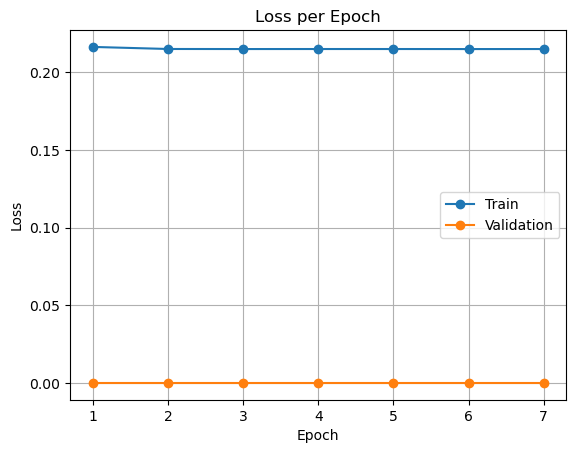

0 0 272213 4122388
Précision :  0
Rappel :  0.0
F1 score : 0
MCC :  0
Accuracy :  0.9380574027084597
IoU :  0.0


In [27]:
model = Model2(k).to(device)

learning_rate = 0.001
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

patience = 5

train_losses = []
val_losses = []

train(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, train_losses, val_losses, patience)
afficher_loss(train_losses, val_losses)
resultat(model, validation_dataloader)

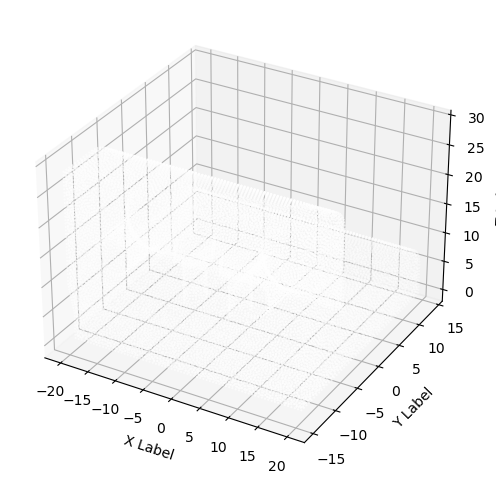

In [28]:
afficher_exemple(model, afficher_dataloader)

On va ajouter une couche intermédiaire en plus.

In [29]:
class Model3(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(k*3+3, k),
            nn.BatchNorm1d(k),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(k, k),
            nn.BatchNorm1d(k),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(k, 2)
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

  5%|▌         | 5/100 [11:39<3:41:31, 139.91s/it]

Early stop


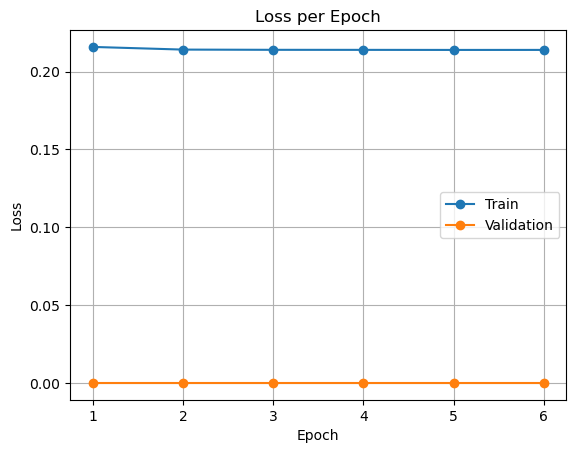

0 0 272213 4122388
Précision :  0
Rappel :  0.0
F1 score : 0
MCC :  0
Accuracy :  0.9380574027084597
IoU :  0.0


In [30]:
model = Model3(k).to(device)

learning_rate = 0.001
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

patience = 5

train_losses = []
val_losses = []

train(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, train_losses, val_losses, patience)
afficher_loss(train_losses, val_losses)
resultat(model, validation_dataloader)

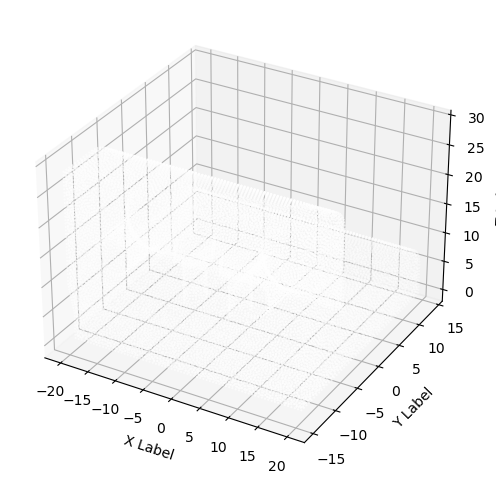

In [31]:
afficher_exemple(model, afficher_dataloader)

## Ajout prétraitement 

On va ajouter un centrage des points autour du point qu'il faut évaluer.

In [32]:
class ModelPretraitement(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(k*3+3, k),
            nn.ReLU(),
            nn.Linear(k, 2)
        )

    def forward(self, x):
        centers = x[:, :3]
        x = x.view(x.shape[0], x.shape[1] // 3, 3)
        x = (x - centers.unsqueeze(1))
        x = x.view(x.shape[0], -1)

        x = self.linear_relu_stack(x)
        return x

 13%|█▎        | 13/100 [13:20<1:29:18, 61.59s/it]

Early stop


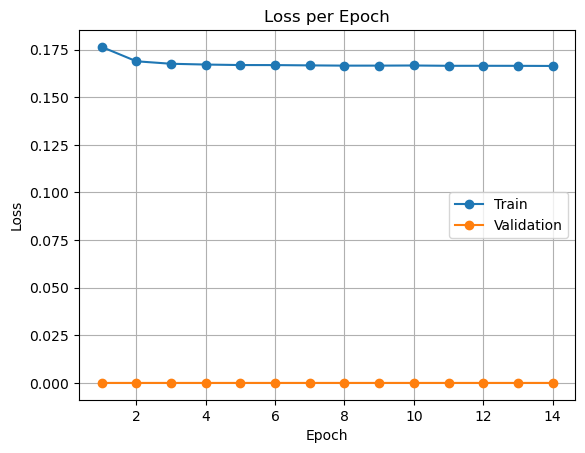

9385 39952 232261 4113003
Précision :  0.8097776516610252
Rappel :  0.1467674211003883
F1 score : 0.24849634582491056
MCC :  0.3305785653550334
Accuracy :  0.9450129829761564
IoU :  0.14187600764209973


In [33]:
model = ModelPretraitement(k).to(device)

learning_rate = 0.001
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

patience = 5

train_losses = []
val_losses = []

train(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, train_losses, val_losses, patience)
afficher_loss(train_losses, val_losses)
resultat(model, validation_dataloader)

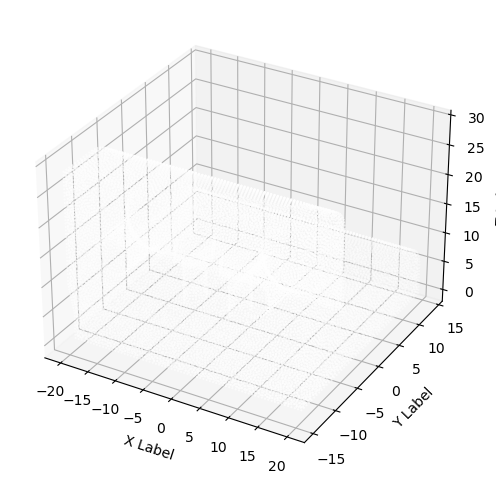

In [34]:
afficher_exemple(model, afficher_dataloader)

In [35]:
class ModelPretraitement3(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(k*3+3, k),
            nn.BatchNorm1d(k),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(k, k),
            nn.BatchNorm1d(k),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(k, 2)
        )      

    def forward(self, x):
        centers = x[:, :3]
        x = x.view(x.shape[0], x.shape[1] // 3, 3)
        x = (x - centers.unsqueeze(1))
        x = x.view(x.shape[0], -1)

        x = self.linear_relu_stack(x)
        return x

  8%|▊         | 8/100 [18:13<3:29:33, 136.67s/it]

Early stop


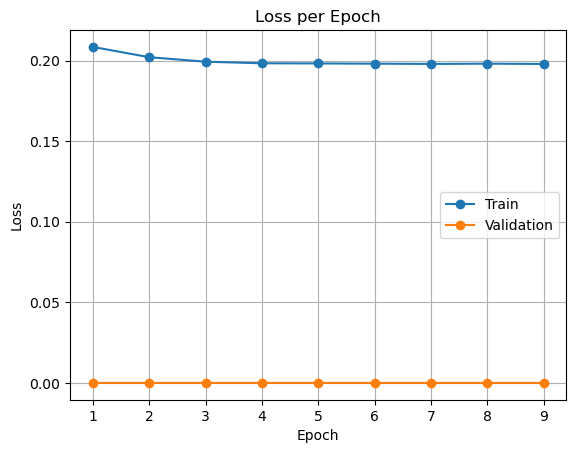

0 0 272213 4122388
Précision :  0
Rappel :  0.0
F1 score : 0
MCC :  0
Accuracy :  0.9380574027084597
IoU :  0.0


In [36]:
model = ModelPretraitement3(k).to(device)

learning_rate = 0.001
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

patience = 5

train_losses = []
val_losses = []

train(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, train_losses, val_losses, patience)
afficher_loss(train_losses, val_losses)
resultat(model, validation_dataloader)

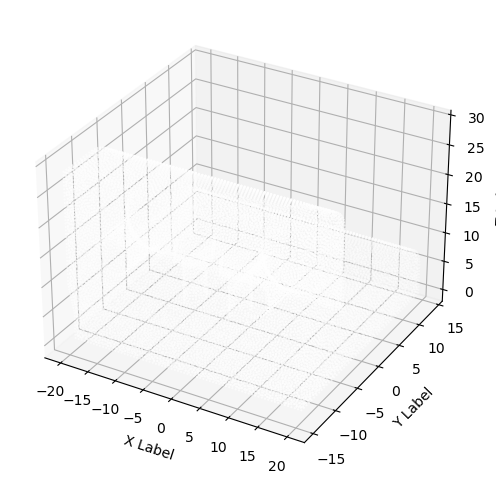

In [37]:
afficher_exemple(model, afficher_dataloader)

On va ajouter une normalisation des points (en entrée).

In [38]:
class ModelPretraitement11(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(k*3+3, k),
            nn.ReLU(),
            nn.Linear(k, 2)
        )

    def forward(self, x):
        centers = x[:, :3]
        x = x.view(x.shape[0], x.shape[1] // 3, 3)        
        x = (x - centers.unsqueeze(1))
        x = F.normalize(x, dim=2)
        x = x.view(x.shape[0], -1)
        
        x = self.linear_relu_stack(x)
        return x

 15%|█▌        | 15/100 [16:52<1:35:37, 67.50s/it]

Early stop


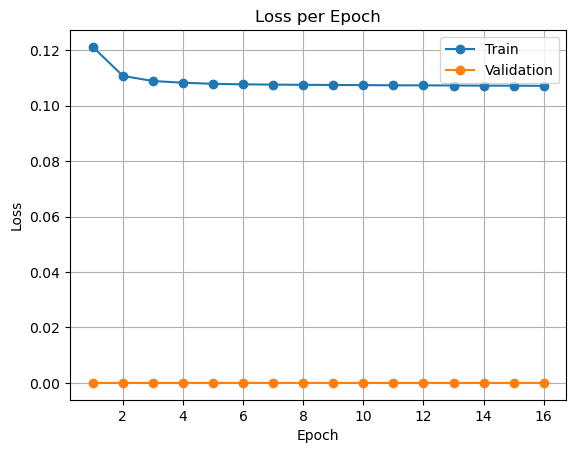

53225 157931 114282 4069163
Précision :  0.7479351758889162
Rappel :  0.580174348763652
F1 score : 0.6534593654123454
MCC :  0.6393588563305835
Accuracy :  0.9618834565413333
IoU :  0.4852875202035411


In [39]:
model = ModelPretraitement11(k).to(device)

learning_rate = 0.001
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

patience = 5

train_losses = []
val_losses = []

train(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, train_losses, val_losses, patience)
afficher_loss(train_losses, val_losses)
resultat(model, validation_dataloader)

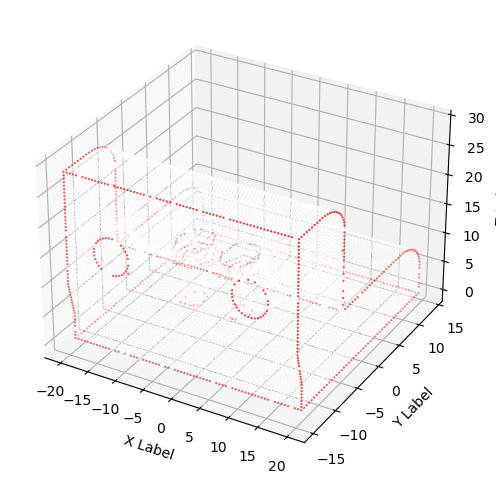

In [40]:
afficher_exemple(model, afficher_dataloader)

En le lançant plusieurs fois j'obtiens une précision autour de 70% et un rappel autour de 60%